In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

E: Package 'python-software-properties' has no installation candidate
Selecting previously unselected package google-drive-ocamlfuse.
(Reading database ... 135004 files and directories currently installed.)
Preparing to unpack .../google-drive-ocamlfuse_0.7.15-0ubuntu1~ubuntu18.04.1_amd64.deb ...
Unpacking google-drive-ocamlfuse (0.7.15-0ubuntu1~ubuntu18.04.1) ...
Setting up google-drive-ocamlfuse (0.7.15-0ubuntu1~ubuntu18.04.1) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope

In [3]:
!ls

adc.json  drive  sample_data


---------------------------------------------------分割线

----------------------------------------------

In [4]:
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import numpy as np
import os
from keras import backend as K
from keras.preprocessing.image import load_img, save_img, img_to_array
import matplotlib.pyplot as plt
from keras.applications import vgg19
from keras.models import Model
#from keras import optimizers
from scipy.optimize import fmin_l_bfgs_b
#from keras.applications.vgg19 import VGG19
#vgg19_weights = 'vgg19_weights_tf_dim_ordering_tf_kernels_notop.h5'
#vgg19 = VGG19(include_top = False, weights=vgg19_weights)
print(os.listdir("../content/drive/My Drive/Colab Notebooks"))

# Any results you write to the current directory are saved as output.

Using TensorFlow backend.


['best-artworks-of-all-time', 'image-classification', 'Style Transfer.ipynb', 'vgg19', 'Photo', '“Style Transfer.ipynb”的副本']


In [0]:
StylePath = '../content/drive/My Drive/Colab Notebooks/best-artworks-of-all-time/images/images/'
ContentPath = '../content/drive/My Drive/Colab Notebooks/Photo/'

In [0]:
base_image_path = ContentPath+'waseda.jpg'
style_image_path = StylePath+'Vincent_van_Gogh/Vincent_van_Gogh_875.jpg'

In [8]:
print(os.listdir("../content/drive/My Drive/Colab Notebooks/Photo"))

['udon1.jpeg', 'udon2.jpeg', 'waseda.jpg']


In [0]:
# dimensions of the generated picture.
width, height = load_img(base_image_path).size
img_nrows = 400
img_ncols = int(width * img_nrows / height)

In [0]:
def preprocess_image(image_path):
    from keras.applications import vgg19
    img = load_img(image_path, target_size=(img_nrows, img_ncols))
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = vgg19.preprocess_input(img)
    return img

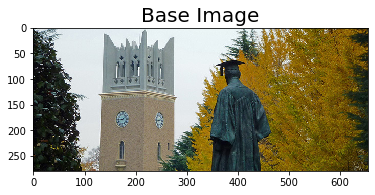

In [13]:
plt.figure()
plt.title("Base Image",fontsize=20)
img1 = load_img(ContentPath+'waseda.jpg')
plt.imshow(img1)

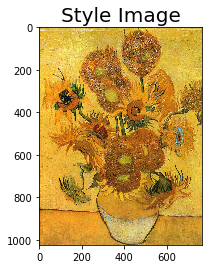

In [18]:
plt.figure()
plt.title("Style Image",fontsize=20)
img1 = load_img(StylePath+'Vincent_van_Gogh/Vincent_van_Gogh_875.jpg')
plt.imshow(img1)

In [0]:
# get tensor representations of our images

base_image = K.variable(preprocess_image(base_image_path))
style_reference_image = K.variable(preprocess_image(style_image_path))

In [52]:
K.image_data_format()

'channels_last'

In [0]:
# this will contain our generated image
if K.image_data_format() == 'channels_first':
    combination_image = K.placeholder((1,3,img_nrows, img_ncols))
else:
    combination_image = K.placeholder((1,img_nrows, img_ncols,3))

In [0]:
# combine the 3 images into a single Keras tensor
input_tensor = K.concatenate([base_image,
                              style_reference_image,
                              combination_image
                              ], axis=0)

In [55]:
# build the VGG19 network with our 3 images as input
# the model will be loaded with pre-trained ImageNet weights
from keras.applications.vgg19 import VGG19
vgg19_weights = '../content/drive/My Drive/Colab Notebooks/vgg19/vgg19_weights_tf_dim_ordering_tf_kernels_notop.h5'
model = VGG19(input_tensor=input_tensor,
              include_top = False,
              weights=vgg19_weights)
#model = vgg19.VGG19(input_tensor=input_tensor,
#                    weights='imagenet', include_top=False)
print('Model loaded.')


Model loaded.


In [0]:
# Content layer where will pull our feature maps
content_layers = ['block5_conv2'] 

# Style layer we are interested in
style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1', 
                'block4_conv1',
                'block5_conv1'
               ]

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

In [25]:
outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])
print(outputs_dict['block5_conv2'])

Tensor("block5_conv2/Relu:0", shape=(3, 25, 58, 512), dtype=float32)


In [0]:
# an auxiliary loss function
# designed to maintain the "content" of the
# base image in the generated image
def get_content_loss(base_content, target):
    return K.sum(K.square(target - base_content))

In [0]:
import tensorflow as tf
# the gram matrix of an image tensor (feature-wise outer product)
def gram_matrix(input_tensor):
    assert K.ndim(input_tensor)==3
    #if K.image_data_format() == 'channels_first':
    #    features = K.batch_flatten(input_tensor)
    #else:
    #    features = K.batch_flatten(K.permute_dimensions(input_tensor,(2,0,1)))
    #gram = K.dot(features, K.transpose(features))
    channels = int(input_tensor.shape[-1])
    a = tf.reshape(input_tensor, [-1, channels])
    n = tf.shape(a)[0]
    gram = tf.matmul(a, a, transpose_a=True)
    return gram#/tf.cast(n, tf.float32)

def get_style_loss(style, combination):
    assert K.ndim(style) == 3
    assert K.ndim(combination) == 3
    S = gram_matrix(style)
    C = gram_matrix(combination)
    channels = 3
    size = img_nrows*img_ncols
    return K.sum(K.square(S - C))#/(4.0 * (channels ** 2) * (size ** 2))
    

In [0]:
# Get output layers corresponding to style and content layers 
#style_outputs = [model.get_layer(name).output for name in style_layers]
#content_outputs = [model.get_layer(name).output for name in content_layers]
#model_outputs = style_outputs + content_outputs

In [0]:
# Get the style and content feature representations from our model  
#style_features = [style_layer[0] for style_layer in model_outputs[:num_style_layers]]
#content_features = [content_layer[1] for content_layer in model_outputs[num_style_layers:]]

In [0]:
#gram_style_features = [gram_matrix(style_feature) for style_feature in style_features]

In [0]:
#style_output_features = model_outputs[:num_style_layers]
#content_output_features = model_outputs[num_style_layers:]
# Accumulate style losses from all layers
# Here, we equally weight each contribution of each loss layer
#weight_per_style_layer = 1.0 / float(num_style_layers)
#loss = K.variable(0.0)
#style_score = 0
#content_score = 0
    
#for target_style, comb_style in zip(gram_style_features, style_output_features):
#    style_score += weight_per_style_layer * get_style_loss(comb_style[0], target_style)
# Accumulate content losses from all layers 
#weight_per_content_layer = 1.0 / float(num_content_layers)
#for target_content, comb_content in zip(content_features, content_output_features):
#    content_score += weight_per_content_layer* get_content_loss(comb_content[0], target_content)

#style_score *= style_weight
#content_score *= content_weight

# Get total loss
#loss = style_score + content_score 

In [42]:
content_weight=0.025 
style_weight=1.0
# combine these loss functions into a single scalar
loss = K.variable(0.0)
layer_features = outputs_dict['block5_conv2']
base_image_features = layer_features[0, :, :, :]
combination_features = layer_features[2, :, :, :]
print('Layer Feature for Content Layers :: '+str(layer_features))
print('Base Image Feature :: '+str(base_image_features))
print('Combination Image Feature for Content Layers:: '+str(combination_features)+'\n')
loss += content_weight * get_content_loss(base_image_features,
                                      combination_features)

feature_layers = ['block1_conv1', 'block2_conv1',
                  'block3_conv1', 'block4_conv1',
                  'block5_conv1']
for layer_name in feature_layers:
    layer_features = outputs_dict[layer_name]
    style_reference_features = layer_features[1, :, :, :]
    combination_features = layer_features[2, :, :, :]
    print('Layer Feature for Style Layers :: '+str(layer_features))
    print('Style Image Feature :: '+str(style_reference_features))
    print('Combination Image Feature for Style Layers:: '+str(combination_features)+'\n')
    sl = get_style_loss(style_reference_features, combination_features)
    loss += (style_weight / len(feature_layers)) * sl


Layer Feature for Content Layers :: Tensor("block5_conv2/Relu:0", shape=(3, 25, 58, 512), dtype=float32)
Base Image Feature :: Tensor("strided_slice_22:0", shape=(25, 58, 512), dtype=float32)
Combination Image Feature for Content Layers:: Tensor("strided_slice_23:0", shape=(25, 58, 512), dtype=float32)

Layer Feature for Style Layers :: Tensor("block1_conv1/Relu:0", shape=(3, 400, 935, 64), dtype=float32)
Style Image Feature :: Tensor("strided_slice_24:0", shape=(400, 935, 64), dtype=float32)
Combination Image Feature for Style Layers:: Tensor("strided_slice_25:0", shape=(400, 935, 64), dtype=float32)

Layer Feature for Style Layers :: Tensor("block2_conv1/Relu:0", shape=(3, 200, 467, 128), dtype=float32)
Style Image Feature :: Tensor("strided_slice_28:0", shape=(200, 467, 128), dtype=float32)
Combination Image Feature for Style Layers:: Tensor("strided_slice_29:0", shape=(200, 467, 128), dtype=float32)

Layer Feature for Style Layers :: Tensor("block3_conv1/Relu:0", shape=(3, 100, 233

In [0]:
def deprocess_image(x):
    if K.image_data_format() == 'channels_first':
        x = x.reshape((3, img_nrows, img_ncols))
        x = x.transpose((1, 2, 0))
    else:
        x = x.reshape((img_nrows, img_ncols, 3))
    # Remove zero-center by mean pixel
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    # 'BGR'->'RGB'
    x = x[:, :, ::-1]
    x = np.clip(x, 0, 255).astype('uint8')
    return x

In [44]:
# get the gradients of the generated image wrt the loss
grads = K.gradients(loss, combination_image)
grads

[<tf.Tensor 'gradients_1/concat_grad/Slice_2:0' shape=(1, 400, 935, 3) dtype=float32>]

In [45]:
outputs = [loss]
if isinstance(grads, (list,tuple)):
    outputs += grads
else:
    outputs.append(grads)
f_outputs = K.function([combination_image], outputs)
f_outputs

In [0]:
# run scipy-based optimization (L-BFGS) over the pixels of the generated image
# so as to minimize the neural style loss
x_opt = preprocess_image(base_image_path)

In [0]:
def eval_loss_and_grads(x):
    if K.image_data_format() == 'channels_first':
        x = x.reshape((1, 3, img_nrows, img_ncols))
    else:
        x = x.reshape((1, img_nrows, img_ncols, 3))
    outs = f_outputs([x])
    loss_value = outs[0]
    if len(outs[1:]) == 1:
        grad_values = outs[1].flatten().astype('float64')
    else:
        grad_values = np.array(outs[1:]).flatten().astype('float64')
    return loss_value, grad_values


In [0]:
class Evaluator(object):

    def __init__(self):
        self.loss_value = None
        self.grads_values = None

    def loss(self, x):
        assert self.loss_value is None
        loss_value, grad_values = eval_loss_and_grads(x)
        self.loss_value = loss_value
        self.grad_values = grad_values
        return self.loss_value

    def grads(self, x):
        assert self.loss_value is not None
        grad_values = np.copy(self.grad_values)
        self.loss_value = None
        self.grad_values = None
        return grad_values

In [0]:
evaluator = Evaluator()

In [50]:
iterations=2
# Store our best result
best_loss, best_img = float('inf'), None
for i in range(iterations):
    print('Start of iteration', i)
    x_opt, min_val, info= fmin_l_bfgs_b(evaluator.loss, 
                                        x_opt.flatten(), 
                                        fprime=evaluator.grads,
                                        maxfun=20,
                                        disp=True,
                                       )
    print('Current loss value:', min_val)
    if min_val < best_loss:
        # Update best loss and best image from total loss. 
        best_loss = min_val
        best_img = x_opt.copy()

Start of iteration 0
Current loss value: 5.980673e+21
Start of iteration 1
Current loss value: 3.454678e+21


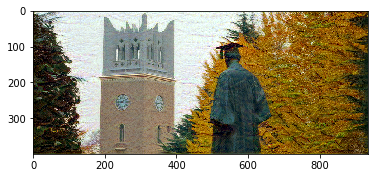

In [56]:
# save current generated image
imgx = deprocess_image(best_img.copy())
plt.imshow(imgx)

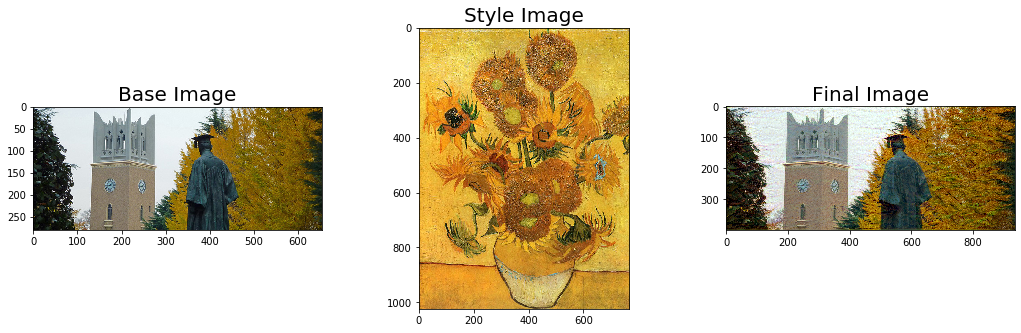

In [57]:
plt.figure(figsize=(30,30))
plt.subplot(5,5,1)
plt.title("Base Image",fontsize=20)
img_base = load_img(base_image_path)
plt.imshow(img_base)

plt.subplot(5,5,1+1)
plt.title("Style Image",fontsize=20)
img_style = load_img(style_image_path)
plt.imshow(img_style)

plt.subplot(5,5,1+2)
plt.title("Final Image",fontsize=20)
plt.imshow(imgx)

In [0]:
def preprocess_image_instantiator(image_path,img_nrows,img_ncols):
    from keras.applications import vgg19
    img = load_img(image_path, target_size=(img_nrows, img_ncols))
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = vgg19.preprocess_input(img)
    return img

In [0]:
def Run_StyleTransfer(base_image_path, style_image_path):
    
    width, height = load_img(base_image_path).size
    img_nrows = 400
    img_ncols = int(width * img_nrows / height)
    
    base_image = K.variable(preprocess_image_instantiator(base_image_path,img_nrows,img_ncols))
    style_reference_image = K.variable(preprocess_image_instantiator(style_image_path,img_nrows,img_ncols))
    
    if K.image_data_format() == 'channels_first':
        combination_image = K.placeholder((1,3,img_nrows, img_ncols))
    else:
        combination_image = K.placeholder((1,img_nrows, img_ncols,3))
        
    input_tensor = K.concatenate([base_image,
                                  style_reference_image,
                                  combination_image
                                  ], axis=0)
    from keras.applications.vgg19 import VGG19
    vgg19_weights = '../content/drive/My Drive/Colab Notebooks/vgg19/vgg19_weights_tf_dim_ordering_tf_kernels_notop.h5'
    model = VGG19(input_tensor=input_tensor,
                  include_top = False,
                  weights=vgg19_weights)
    outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])
    
    content_weight=0.025 
    style_weight=1.0
    # combine these loss functions into a single scalar
    loss = K.variable(0.0)
    layer_features = outputs_dict['block5_conv2']
    base_image_features = layer_features[0, :, :, :]
    combination_features = layer_features[2, :, :, :]
    #print('Layer Feature for Content Layers :: '+str(layer_features))
    #print('Base Image Feature :: '+str(base_image_features))
    #print('Combination Image Feature for Content Layers:: '+str(combination_image_features))
    loss += content_weight * get_content_loss(base_image_features,
                                          combination_features)

    feature_layers = ['block1_conv1', 'block2_conv1',
                      'block3_conv1', 'block4_conv1',
                      'block5_conv1']
    for layer_name in feature_layers:
        layer_features = outputs_dict[layer_name]
        style_reference_features = layer_features[1, :, :, :]
        combination_features = layer_features[2, :, :, :]
        #print('Layer Feature for Style Layers :: '+str(layer_features))
        #print('Style Image Feature :: '+str(style_reference_features))
        #print('Combination Image Feature for Style Layers:: '+str(combination_features))
        sl = get_style_loss(style_reference_features, combination_features)
        loss += (style_weight / len(feature_layers)) * sl
        
    grads = K.gradients(loss, combination_image)
    
    outputs = [loss]
    if isinstance(grads, (list,tuple)):
        outputs += grads
    else:
        outputs.append(grads)
    f_outputs = K.function([combination_image], outputs)
    
    x_opt = preprocess_image(base_image_path)
    
    evaluator = Evaluator()
    iterations=200
    # Store our best result
    best_loss, best_img = float('inf'), None
    for i in range(iterations):
        #print('Start of iteration', i)
        x_opt, min_val, info= fmin_l_bfgs_b(evaluator.loss, 
                                            x_opt.flatten(), 
                                            fprime=evaluator.grads,
                                            maxfun=20,
                                            disp=True,
                                           )
        #print('Current loss value:', min_val)
        if min_val < best_loss:
            # Update best loss and best image from total loss. 
            best_loss = min_val
            best_img = x_opt.copy()
    imgx = deprocess_image(best_img.copy())
    
    return imgx

In [0]:
base_image_path_1 = '../content/drive/My Drive/Colab Notebooks/Photo/udon2.jpeg'
plt.figure(figsize=(30,30))
plt.subplot(5,5,1)
plt.title("Base Image",fontsize=20)
img_base = load_img(base_image_path_1)
plt.imshow(img_base)

style_image_path_1 = '../content/drive/My Drive/Colab Notebooks/best-artworks-of-all-time/images/images/Paul_Klee/Paul_Klee_96.jpg'
plt.subplot(5,5,1+1)
plt.title("Style Image",fontsize=20)
img_style = load_img(style_image_path_1)
plt.imshow(img_style)

plt.subplot(5,5,1+2)
imgg = Run_StyleTransfer(base_image_path_1, style_image_path_1)
plt.title("Final Image",fontsize=20)
plt.imshow(imgg)